# Homework 7: Gene expression, by experiment

#### **Please read the following instructions carefully before you continue.**

This template notebook is for Homework 7, due Thursday, May 30th, 2024.

To use this template, click `File` > `Save a copy in Drive`. You now have your own editable copy to which you can add your code. However, before you make changes, note that we've scaffolded this notebook to help get you started:

- We've already written `import` statements for all the modules you should need. This week, you could feasibly do everything without importing any external modules; do whatever is most helpful for you.
- We provide an introduction that lays out one potential approach for solving the problem, explaining what each logical "chunk" of your code ought to accomplish. You can use this as a starting point for writing your own code.  

Of course, if you'd rather do your own thing, you are not required to follow the path we've laid out, or use the modules we've recommended. However, a few things _are_ required (refer to the [Intro to Colab](https://colab.research.google.com/drive/1fq_HaiuYb1L18uGcoA3eGs6taiUafR-6?usp=sharing) notebook):

- _Literate style._ Dumping everything into a single, monstrous code cell is illegible and unacceptable. Remember to divide your code into reasonable, logical chunks, and to follow up each code cell with a text cell that explains and interprets the results. Try to minimize copy-and-pasting; instead, define functions and use thoughtful iteration to accomplish repetitive tasks.
- _Comments._ That said, writing "literate" code is not an excuse to avoid writing comments :)
- _Problem labels/numbers._ Please use text cells to clearly label where your solution to one problem ends, and the next begins.

Remember that a human is going to read and grade your notebook, so it is in your best interest to help them understand your work clearly. Your finished solution to a given problem should flow coherently from one code cell to the next. (Our "scaffold" helps you do this!)

If you get stuck, remember that [tutorials](https://bi1.caltech.edu/2023/tutorials) are held in-person each week.

---

## Introduction

This special "computational project" set serves as the culmination of all your hard work programming this quarter! You'll draw from many of the image segmentation skills you learned in HW 1, and combine them with the plotting you learned to do for HW 3 and 4. Finally, you'll compare your results with the theoretical predictions you made in HW 6.

Most excitingly, you'll use it all to study a real-world dataset, and recapitulate the analysis done in a real-world paper published just a few years ago. In other words, you are going to get your best taste yet of _real_ biological research.

This time, most of the information to get you started isn't included in this template file; instead, it's in the problem set text itself, as well as in the tutorial recordings and notebooks. Reach out if you have any questions!

**Question 1a**

Equation 1)

\begin{align*}
  &\frac{1}{1 + \frac{R}{Nns}*e^{\frac{-Δεr}{KbT}}} = fold-change \\
  &1 + \frac{R}{N_{ns}}\cdot e^{\frac{-Δε_r}{K_BT}} = \frac{1}{\text{fold-change}} \\
  &\frac{R}{N_{ns}}*e^{\frac{-Δε_r}{K_BT}} = \frac{1}{\text{fold-change}} - 1 \\
  &e^{\frac{-Δε_r}{K_BT}} = \frac{N_{ns}}{R\cdot\text{fold-change}} - \frac{N_{ns}}{R} \\
  &ln(e^{\frac{-Δε_r}{K_BT}}) = ln(\frac{N_{ns}}{R\cdot\text{fold-change}} - \frac{N_{ns}}{R}) \\
  &\frac{-Δε_r}{K_BT} = ln(\frac{N_{ns}}{R}(\frac{1}{fold-change} - 1)) \\
  &Δεr = {K_BT}[ln(\frac{N_{ns}}{R}) + ln(\frac{1}{fold-change} - 1)]\\
\end{align*}



In [1]:
## relevant imports
# the usual suspects
import numpy as np
import matplotlib.pyplot as plt

# working with filenames
import glob

# image processing
import skimage.io
import skimage.exposure
import skimage.measure

# csv work
import pandas as pd

# least-squares regression
import scipy.optimize

# access files from your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Question 1b

01 epsillion -15.667019345677293
02 epsillion -14.15846651530383
03 epsillion -9.872950203620379


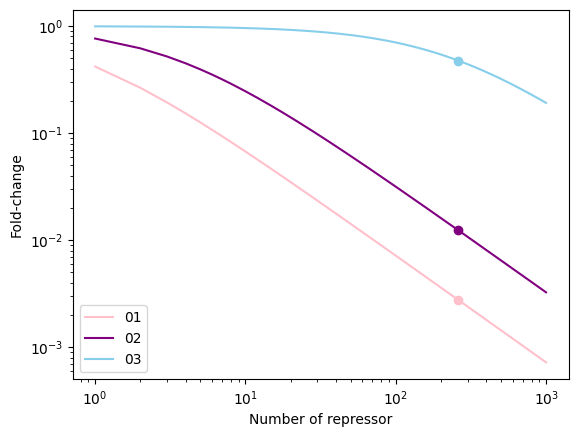

In [2]:
def fold_change(R, Nns, delta):
  num = 1/(1+ (R/(Nns)) * np.exp(-delta))
  return num;

def change_eq(R, Nns, delta):
  num = np.log(R)- np.log((Nns)) - np.log(1/delta -1)
  return num;

Nns = 4.6*10**6;
R = 260;

one = change_eq(R, Nns, 2.77*(10**(-3)));
two = change_eq(R, Nns, 1.24*(10**(-2)));
three = change_eq(R, Nns, 4.77*(10**(-1)));

print("01 epsillion", one);
print("02 epsillion", two);
print("03 epsillion", three);

nums = list(range(1,10**3))

fc_1 = [];
fc_2 = []
fc_3 = []


for i in nums:
  fc_1.append(fold_change(i, Nns, one));

for i in nums:
  fc_2.append(fold_change(i, Nns, two));

for i in nums:
  fc_3.append(fold_change(i, Nns, three));



plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of repressor')
plt.ylabel('Fold-change')


plt.plot(nums, fc_1, color = "pink", label = "01");
plt.plot(260, 2.77*(10**(-3)), marker="o", color = "pink"),



plt.plot(nums, fc_2, color = "purple", label = "02");
plt.plot(260, 1.24*(10**(-2)), marker="o", color = "purple")


plt.plot(nums, fc_3, color = "skyblue", label = "03");
plt.plot(260, 4.77*(10**(-1)), marker="o", color = "skyblue")

plt.legend()



## Question 1c



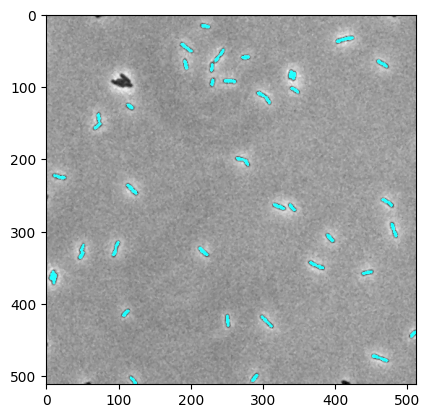

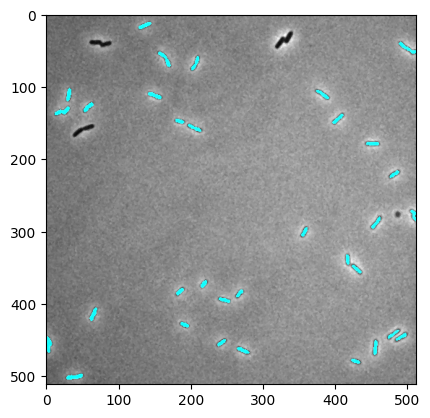

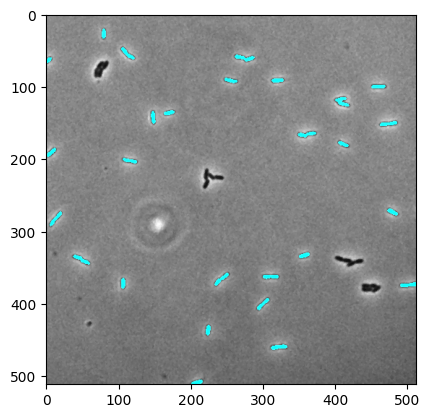

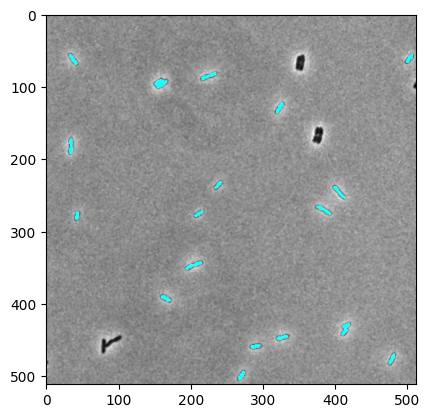

In [3]:
#got help form the code tutorial

def segment_im(im_phase, ip_dist=0.160, area_bounds=(1,4), phase_thresh=0.3, show_mask=False):

  normed = (im_phase - im_phase.min()) / (im_phase.max() - im_phase.min())
  thresh = normed < phase_thresh

  lab, obj = skimage.measure.label(thresh, return_num=True)

  good_cells = np.zeros_like(thresh)
  for i in range(obj):
      cell = (lab == i + 1)
      area = np.sum(cell)
      cell_area = area * ip_dist**2
      if (cell_area > area_bounds[0]) and (cell_area < area_bounds[1]):
            good_cells += cell

  if show_mask:
      copy = np.copy(normed)
      copy[good_cells] = 1.0
      rgb = np.dstack((normed, copy, copy))
      plt.imshow(rgb)
      plt.show()

  return good_cells


image_link = '/content/drive/MyDrive/lacI_titration/'

images = ['O1_delta_phase_pos_01.tif', 'O2_delta_phase_pos_01.tif', 'O3_auto_phase_pos_01.tif', 'O1_R60_phase_pos_01.tif']

for i in images:
  image = skimage.io.imread(image_link + i)
  segmentation_mask = segment_im(image, ip_dist=0.160, area_bounds=(1, 4),
                      phase_thresh=0.3, show_mask=True)


## Question 1d

In [4]:

def extract_intensities(im_phase, im_fluor):

  mask = segment_im(im_phase)


  lab, num_cells = skimage.measure.label(mask, return_num=True)
  intensity = np.zeros(num_cells)

  for i in range(num_cells):
    cell = (lab == i + 1)
    total = np.sum(cell * im_fluor)
    intensity[i] = total

  return intensity



files = ['O1_delta_yfp_pos_01.tif', 'O2_delta_yfp_pos_01.tif',
                'O3_auto_yfp_pos_01.tif', 'O1_R60_yfp_pos_01.tif']




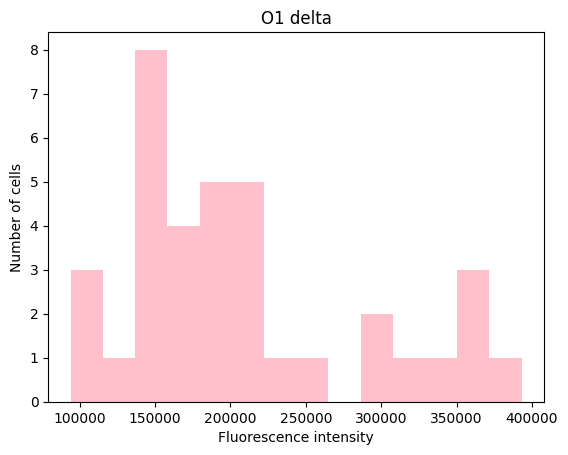

In [5]:
#01 delta

fig, ax = plt.subplots()
ax.set_xlabel("Fluorescence intensity")
ax.set_ylabel("Number of cells")
ax.set_title("O1 delta")

im_phase = skimage.io.imread(image_link + images[0])
im_fluor = skimage.io.imread(image_link + files[0])
intensity = extract_intensities(im_phase, im_fluor)

num_bins = 15
hist_bins = np.linspace(min(intensity), max(intensity), num_bins)
ax.hist(intensity, bins=hist_bins, color = "pink")


plt.show()



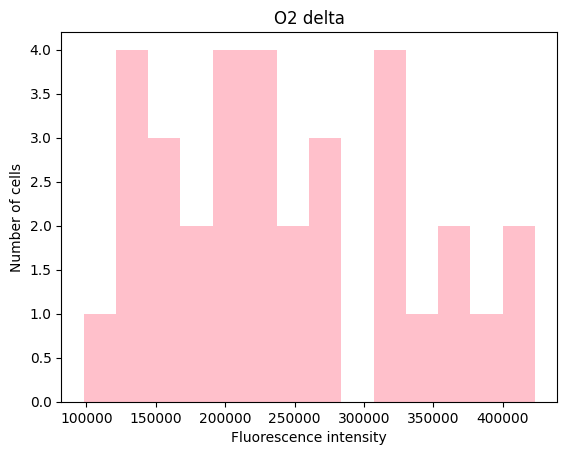

In [6]:
#02 delta

fig, ax = plt.subplots()
ax.set_xlabel("Fluorescence intensity")
ax.set_ylabel("Number of cells")
ax.set_title("O2 delta")



im_phase = skimage.io.imread(image_link + images[1])
im_fluor = skimage.io.imread(image_link + files[1])
intensity = extract_intensities(im_phase, im_fluor)

num_bins = 15
hist_bins = np.linspace(min(intensity), max(intensity), num_bins)
ax.hist(intensity, bins=hist_bins, color = "pink")


plt.show()


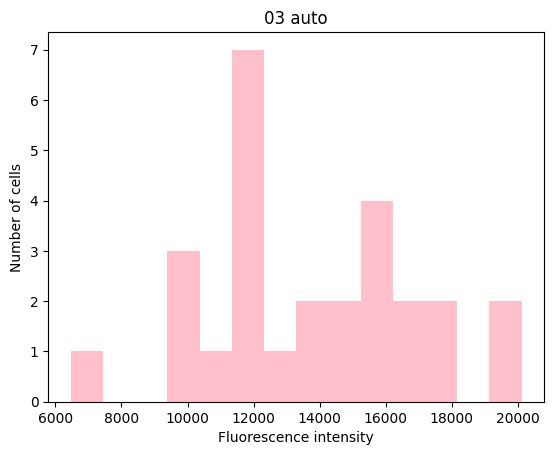

In [7]:
#03 auto

fig, ax = plt.subplots()
ax.set_xlabel("Fluorescence intensity")
ax.set_ylabel("Number of cells")
ax.set_title("03 auto")


im_phase = skimage.io.imread(image_link + images[2])
im_fluor = skimage.io.imread(image_link + files[2])
intensity = extract_intensities(im_phase, im_fluor)

num_bins = 15
hist_bins = np.linspace(min(intensity), max(intensity), num_bins)
ax.hist(intensity, bins=hist_bins, color = "pink")

plt.show()



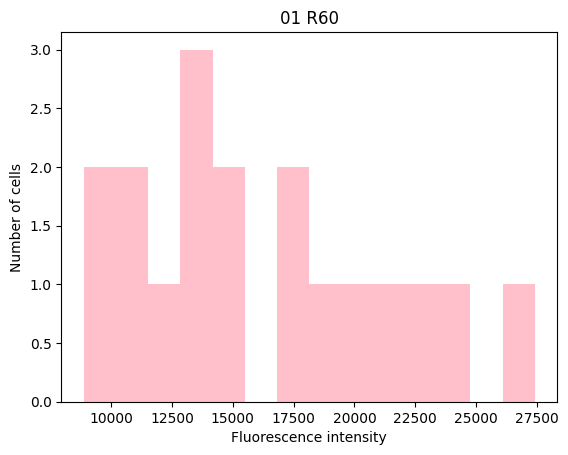

In [8]:
#O1 R60

fig, ax = plt.subplots()
ax.set_xlabel("Fluorescence intensity")
ax.set_ylabel("Number of cells")
ax.set_title("01 R60")


im_phase = skimage.io.imread(image_link + images[3])
im_fluor = skimage.io.imread(image_link + files[3])
intensity = extract_intensities(im_phase, im_fluor)

num_bins = 15
hist_bins = np.linspace(min(intensity), max(intensity), num_bins)
ax.hist(intensity, bins=hist_bins, color = "pink")

plt.show()



## Question 1e

In [9]:

def strain_totals(op, rep):
  phase_filenames =  np.sort(glob.glob(image_link + op + '_'  + rep + '_phase*.tif'))
  fluor_names = np.sort(glob.glob(image_link + op + '_' + rep + '_yfp*.tif'))
  intensities = [];
  for i in range(len(phase_filenames)):
    img_p = skimage.io.imread(phase_filenames[i])
    img_f = skimage.io.imread(fluor_names[i])
    intensity = extract_intensities(img_p, img_f);
    for j in intensity:
      intensities.append(j)
  return intensities;


op = ['O1', 'O2', 'O2', 'O3']
rep = ['auto', 'auto', 'delta', 'delta']


(array([ 45., 130., 175., 150.,  81.,  44.,  32.,  14.,   5.,   1.]),
 array([ 4901. ,  7058.4,  9215.8, 11373.2, 13530.6, 15688. , 17845.4,
        20002.8, 22160.2, 24317.6, 26475. ]),
 <BarContainer object of 10 artists>)

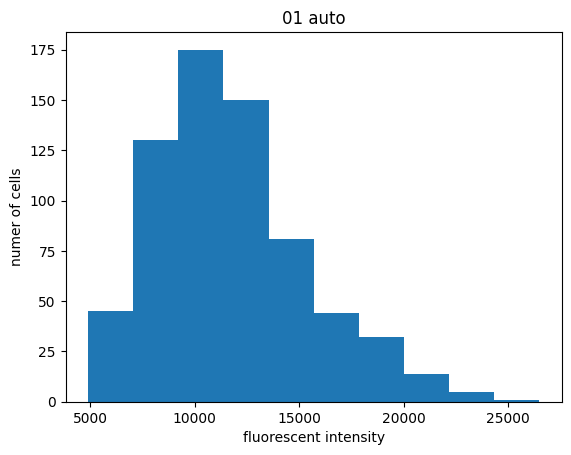

In [10]:
fig, ax = plt.subplots()
ax.set_title('01 auto')
ax.set_xlabel('fluorescent intensity')
ax.set_ylabel('numer of cells')

strain_list = np.asarray(strain_totals(op[0], rep[0]));
plt.hist(strain_list)

(array([ 60., 189., 198.,  96.,  34.,  12.,   2.,   0.,   0.,   1.]),
 array([ 5222. ,  8369.7, 11517.4, 14665.1, 17812.8, 20960.5, 24108.2,
        27255.9, 30403.6, 33551.3, 36699. ]),
 <BarContainer object of 10 artists>)

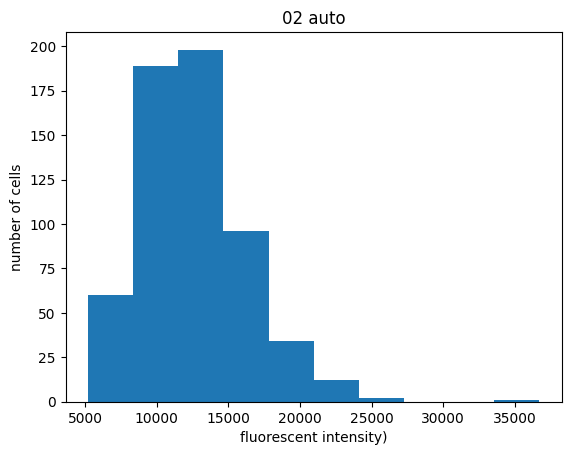

In [11]:
fig, ax = plt.subplots()
ax.set_title('02 auto')
ax.set_xlabel('fluorescent intensity)')
ax.set_ylabel('number of cells')

strain_list = np.asarray(strain_totals(op[1], rep[1]));
plt.hist(strain_list)

(array([  6., 134., 189., 127.,  50.,  21.,  12.,   2.,   0.,   3.]),
 array([   6426. ,  111578.6,  216731.2,  321883.8,  427036.4,  532189. ,
         637341.6,  742494.2,  847646.8,  952799.4, 1057952. ]),
 <BarContainer object of 10 artists>)

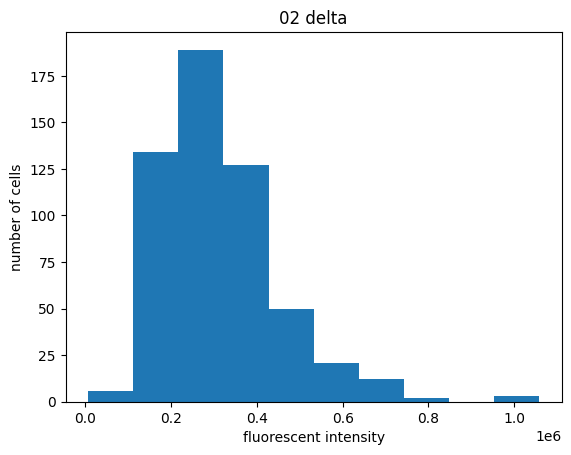

In [12]:
#02 delta

fig, ax = plt.subplots()
ax.set_title('02 delta')
ax.set_xlabel('fluorescent intensity')
ax.set_ylabel('number of cells')

strain_list = np.asarray(strain_totals(op[2], rep[2]));
plt.hist(strain_list)

(array([ 28., 119., 177.,  92.,  51.,  29.,   8.,   2.,   2.,   1.]),
 array([   5173. ,  221543.9,  437914.8,  654285.7,  870656.6, 1087027.5,
        1303398.4, 1519769.3, 1736140.2, 1952511.1, 2168882. ]),
 <BarContainer object of 10 artists>)

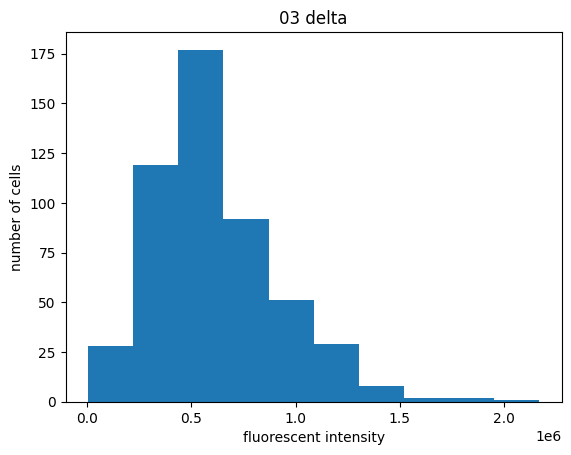

In [13]:
#03 delta

fig, ax = plt.subplots()
ax.set_title('03 delta')
ax.set_xlabel('fluorescent intensity')
ax.set_ylabel('number of cells')

strain_list = np.asarray(strain_totals(op[3], rep[3]));
plt.hist(strain_list)

## Question 1f

In [14]:

#change varaibles names
ops = ['O1', 'O2', 'O3']
rep_names= ['R22', 'R60', 'R124', 'R260']
rep_nums=[22, 60, 124, 260]


mean_micro = np.zeros((len(ops), len(rep_names)))
fc_micro=np.zeros((len(ops), len(rep_names)))


for i in range(len(ops)):
  op=ops[i];
  auto= np.mean(strain_totals(op, 'auto'))
  delta = np.mean(strain_totals(op, 'delta'))
  for j in range(len(rep_names)):
    repressor = rep_names[j];
    mean_micro[i, j]= np.mean(strain_totals(op, repressor))
    fc_micro[i, j]=(mean_micro[i,j]-auto)/(delta -auto)



print(fc_micro)


[[0.0210242  0.01909085 0.0097609  0.00557686]
 [0.14532349 0.04216874 0.0148685  0.00973137]
 [0.89913028 0.74661113 0.96938875 0.73675618]]


## Question 1g

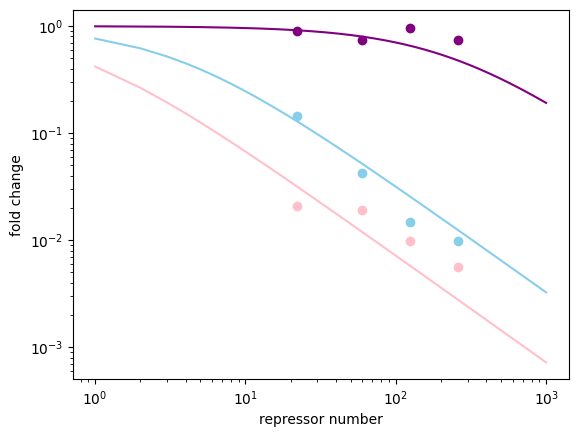

In [15]:


plt.xscale('log')
plt.yscale('log')


plt.xlabel('repressor number')
plt.ylabel('fold change')


plt.plot(nums, fc_1, color = "pink");
plt.plot(nums, fc_2, color = "skyblue");
plt.plot(nums, fc_3, color = "purple");



for i in range(len(ops)):
  if i == 0:
    color = 'pink'
  if i == 1:
    color = 'skyblue'
  if i == 2:
    color = 'purple'
  for j in range(len(rep_nums)):
    plt.plot(rep_nums[j], fc_micro[i][j], marker='o', mfc=color, mec=color)



As we can see in the graph the dots mostly align with the curves from part b, with a couple of outliers. Even so, the outliers are not that extreme from the line. This can be for several reason. One is becuase the curves plotted on data set b were created from only one point. Also, we are looking at the mean intenstities which means that there can be outliers that affect the mean. Outside factors like temperture, computer error when appromzxating and more could lead to those outliers.  

## Question 1h

In [16]:
lacZ_tritation =pd.read_csv('/content/drive/MyDrive/lacZ_titration_data.csv', header=8)


def fold_change_log_theory(R, delta):
  return np.log(1/(1+ R/Nns * np.exp(-delta)))

In [17]:

lac_list = [];
Nns = 4.6*10**6;

for i in range(len(ops)):
  values= lacZ_tritation[lacZ_tritation['operator']==ops[i]]['repressor']
  lacZ_values = np.log(lacZ_tritation[lacZ_tritation['operator']==ops[i]]['fold_change'])
  para = scipy.optimize.curve_fit(fold_change_log_theory, values, lacZ_values)
  lac_list.append(para[0])

print(lac_list[0])
print(lac_list[1])
print(lac_list[2])

print(one)
print(two)
print(three)




[-15.77672204]
[-14.17011337]
[-10.04600127]
-15.667019345677293
-14.15846651530383
-9.872950203620379


As we can see, when looking at the top three values to the bottom three values the values do not change by that much. Thus, in conclusion the least-squares fits do not change that much from the binding energies from a single point

## Question 1i

In [18]:
micro=[]
for i in range(len(ops)):
  popt, pcov = scipy.optimize.curve_fit(fold_change_log_theory, rep_nums, np.log(fc_micro[i]))
  micro.append((popt[0]))



print(micro[0])
print(micro[1])
print(micro[2])


print("Difference 1: ", lac_list[0]- micro[0])
print("Difference 2: ", lac_list[1]- micro[1])
print("Difference 3: ", lac_list[2]- micro[2])

-15.334747885294352
-14.395320177051703
-8.75261549324254
Difference 1:  [-0.44197416]
Difference 2:  [0.22520681]
Difference 3:  [-1.29338577]


The bottom three numbers show the differnces. The differnces are not that big. This indicates that when reversing the process, the epsilon values remain mostly the same compared to the binding energies that were gotten from a single point.

## Question 1j

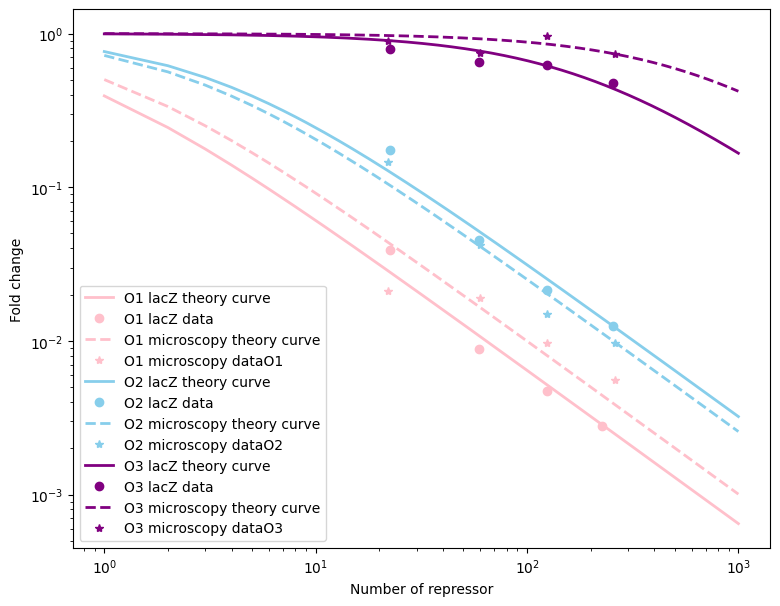

In [19]:

R = np.array(list(range(1,10**3)))

plt.subplots(figsize = (9,7))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of repressor')
plt.ylabel('Fold change')

colors=['pink', 'skyblue', 'purple']

for i in range(len(ops)):

  plt.plot(R, fold_change(R, Nns, lac_list[i]), linewidth=2, label = ops[i] + " lacZ theory curve" , color=colors[i])

  r_values = lacZ_tritation[lacZ_tritation['operator']==ops[i]]['repressor'] #change the varaibles names
  fc_values_lacZ = (lacZ_tritation[lacZ_tritation['operator']==ops[i]]['fold_change'])
  plt.plot(r_values, fc_values_lacZ, 'o', color=colors[i], label = ops[i] + " lacZ data")

  plt.plot(R, fold_change(R, Nns, micro[i] ), linewidth=2, linestyle='--',label = ops[i] + " microscopy theory curve", color=colors[i])
  plt.plot(rep_nums, fc_micro[i,:], '*', label=ops[i] + ' microscopy data'+ ops[i],color=colors[i])

plt.legend();



As we can see from the graph there is not much of a disagreement. Although, there is a slight difference.This is most likely due the the data that was gathered and meeasured than the theroy itself. When getting data there might have been outside factors that cause a slight differnce in the data

---

### Submission instructions

When you're finished, recall the steps for submitting Colab notebooks:

1. Run all the cells from top-to-bottom, in order (`Runtime` > `Run all`).
2. Once the entire notebook has completed running and the output of all cells is visible, save it (`File` > `Save`).
3. Download the notebook in `.ipynb` format (`File` > `Download` > `Download .ipynb`).
4. Rename the file according to the usual convention (`lastname_firstname_hw#.ipynb`), if you haven't already.
5. Upload the file to Canvas.
